In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from astropy.stats import funcs

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

**The Plan**

- read in KIC 2 TIC reference
- read in Kepler periods from Amy McQuillan's paper
- read all the TESS rot estimates from my script
- combine all TESS rot files
- xmatch TESS to Kepler
- Comparison plot!

In [3]:
tess_dir = '/Users/james/Desktop/helloTESS/outputs/'

# if you want ALL the sectors
rfiles = glob(tess_dir + '*rot_out.csv')

In [4]:
# but, we only want Sectors 14 & 15
rot1 = pd.read_csv(tess_dir + 'sector014_rot_out.csv')
rot2 = pd.read_csv(tess_dir + 'sector015_rot_out.csv')

print(rot1.shape, rot2.shape)

(19993, 12) (19996, 12)


Text(0, 0.5, 'L-S Period (days)')

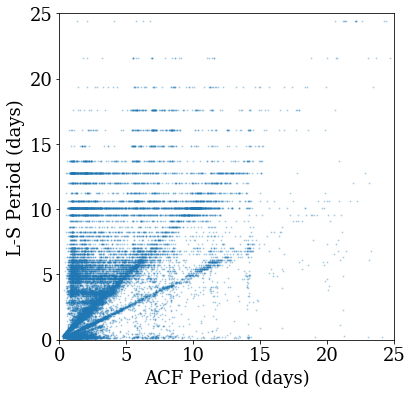

In [5]:
plt.figure(figsize=(6,6))
plt.scatter(rot1['acf_per'],rot1['LSper'], s=1, alpha=0.25)
# plt.scatter(rot2['acf_per'],rot2['LSper'], s=1, alpha=0.25)

plt.xlim(0,25)
plt.ylim(0,25)
plt.xlabel('ACF Period (days)')
plt.ylabel('L-S Period (days)')

In [6]:
KICTIC = pd.read_csv('/Users/james/Dropbox/research_projects/kic2tic/KIC2TIC.csv')

KICTIC.shape

(199421, 2)

In [7]:
rot1.merge(KICTIC, left_on='TIC', right_on='TIC').shape

(1274, 13)

In [8]:
rot2.merge(KICTIC, left_on='TIC', right_on='TIC').shape

(769, 13)

In [9]:
# How many Kepler stars did TESS get short-cadence data for?
pd.concat((rot1.merge(KICTIC, left_on='TIC', right_on='TIC'), 
           rot2.merge(KICTIC, left_on='TIC', right_on='TIC')))['TIC'].unique().size

1359

In [10]:
Kper13 = pd.read_csv('./amq_Period_Table.txt')
Kper14 = pd.read_table('mcquillan2014_tbl1.txt', delim_whitespace=True)
print(Kper13.shape, Kper14.shape)

(1570, 8) (34030, 11)


In [11]:
Kper13.columns

Index(['KID', 'Teff', 'logg', 'Mass', 'Period', 'Period_Err', 'Amplitude',
       'Flag'],
      dtype='object')

In [12]:
Kper14.columns

Index(['KID', 'Teff', 'logg,', 'Mass', 'Period', 'e_Period', 'Rper', 'LPH',
       'w', 'DC', 'Flag'],
      dtype='object')

In [13]:
# Combine McQuillan 2013 & 2014, drop duplicate entries (prefer 2014, I believe)
Kper = pd.concat((Kper14[['KID', 'Period', 'Teff']], 
                  Kper13[['KID', 'Period', 'Teff']])).drop_duplicates(subset='KID')

In [14]:
# add TIC to the Kepler periods
KTper = Kper.merge(KICTIC, left_on='KID', right_on='KIC', how='inner')

KTper.shape

(34154, 5)

In [15]:
# how many Kepler rotators were in Sector 14?
Trot1 = rot1.merge(KTper, left_on='TIC', right_on='TIC')
Trot1.shape

(169, 16)

In [16]:
# how many Kepler rotators were in Sector 155?
Trot2 = rot2.merge(KTper, left_on='TIC', right_on='TIC')
Trot2.shape

(80, 16)

In [17]:
# how many Kepler rotators were in Sector 14 OR 15?
Trot12 = pd.concat((Trot1, Trot2))

print(Trot12['KIC'].size, Trot12['KIC'].unique().size)

249 178


In [18]:
Trot1.columns

Index(['Unnamed: 0', 'TIC', 'LSper', 'LSamp', 'LSmed', 'LSstd', 'acf_pk',
       'acf_per', 'bls_per', 'bls_ampl', 'ecl_num', 'ecl_dep', 'KID', 'Period',
       'Teff', 'KIC'],
      dtype='object')

Text(0, 0.5, 'TESS Period (days)')

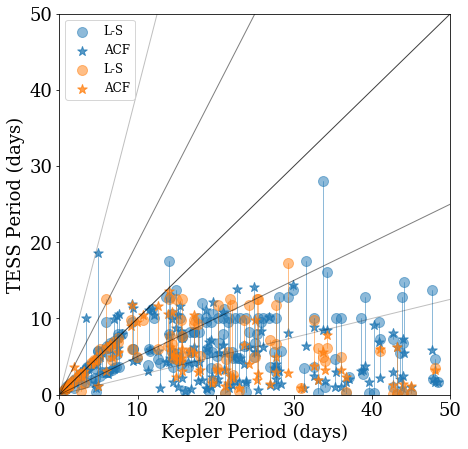

In [19]:
plt.figure(figsize=(7,7))
plt.scatter(Trot1['Period'], Trot1['LSper'], alpha=0.5, c='C0', s=100, label='L-S')
plt.scatter(Trot1['Period'], Trot1['acf_per'], alpha=0.75, c='C0', s=100, marker='*', label='ACF')
for k in range(len(Trot1)):
    plt.plot([Trot1['Period'][k], Trot1['Period'][k]], [Trot1['LSper'][k], Trot1['acf_per'][k]], 
             lw=0.5, c='C0')
    
plt.scatter(Trot2['Period'], Trot2['LSper'], alpha=0.5, c='C1', s=100, label='L-S')
plt.scatter(Trot2['Period'], Trot2['acf_per'], alpha=0.75, c='C1', s=100, marker='*', label='ACF')
for k in range(len(Trot2)):
    plt.plot([Trot2['Period'][k], Trot2['Period'][k]], [Trot2['LSper'][k], Trot2['acf_per'][k]], 
             lw=0.5, c='C1')


plt.plot([.1,50], [.1, 50], c='k', lw=1, alpha=0.75)
plt.plot([.1,50], [.05, 25], c='k', lw=1, alpha=0.5)
plt.plot([.1,50], [.025, 12.5], c='k', lw=1, alpha=0.25)
plt.plot([.1,50], [.2, 100], c='k', lw=1, alpha=0.5)
plt.plot([.1,50], [.4, 200], c='k', lw=1, alpha=0.25)

plt.xlim(0,50)
plt.ylim(0,50)
plt.legend(fontsize=12)

plt.xlabel('Kepler Period (days)')
plt.ylabel('TESS Period (days)')

In [20]:
# pick "good" periods
# this cut is somewhat arbitrary, unfortunately. We need real errors on the periods (e.g. MCMC)
Pcut = 0.05

ok1 = (Trot1['acf_pk'] > Pcut) | (Trot1['LSamp'] > Pcut)
ok2 = (Trot2['acf_pk'] > Pcut) | (Trot2['LSamp'] > Pcut)

print(sum(ok1), sum(ok2))
print(pd.concat((Trot1['KIC'][ok1],Trot2['KIC'][ok2])).unique().size)

76 35
86


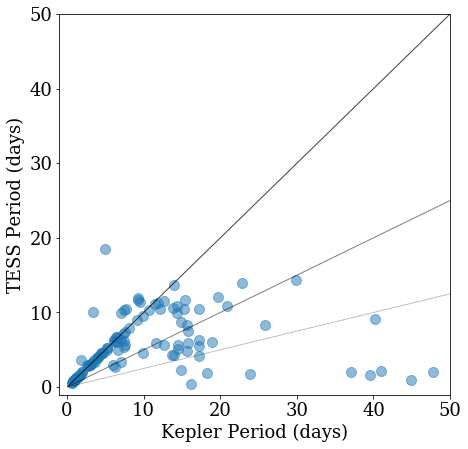

In [21]:
plt.figure(figsize=(7,7))

plt.scatter(Trot1['Period'][ok1], Trot1['acf_per'][ok1], alpha=0.5, c='C0', s=100)
plt.scatter(Trot2['Period'][ok2], Trot2['acf_per'][ok2], alpha=0.5, c='C0', s=100)

plt.plot([.1,50], [.1, 50], c='k', lw=1, alpha=0.75)
plt.plot([.1,50], [.05, 25], c='k', lw=1, alpha=0.5)
plt.plot([.1,50], [.025, 12.5], c='k', lw=1, alpha=0.25)
# plt.plot([.1,50], [.2, 100], c='k', lw=1, alpha=0.5)
# plt.plot([.1,50], [.4, 200], c='k', lw=1, alpha=0.25)

plt.xlim(-1,50)
plt.ylim(-1,50)

plt.xlabel('Kepler Period (days)')
plt.ylabel('TESS Period (days)')
plt.show()

# plt.figure(figsize=(7,7))

# plt.scatter(Trot1['Period'][ok1], Trot1['acf_per'][ok1]/Trot1['Period'][ok1], alpha=0.5, c='C0', s=100)
# plt.scatter(Trot2['Period'][ok2], Trot2['acf_per'][ok2]/Trot2['Period'][ok2], alpha=0.5, c='C0', s=100)

# plt.plot([.1,50], [1,1], c='k', lw=1, alpha=0.75)
# plt.plot([.1,50], [.5,.5], c='k', lw=1, alpha=0.5)
# plt.plot([.1,50], [.25, .25], c='k', lw=1, alpha=0.25)

# plt.xlim(-1,50)
# plt.ylim(0,1.1)

# plt.xlabel('Kepler Period (days)')
# plt.ylabel('TESS / Kepler Period')
# plt.show()


# Recovery Fraction

## ACF periods

Text(0, 0.5, 'Fraction Recovered')

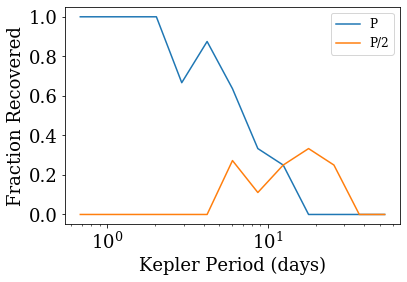

In [22]:
# how close to the period do we need to be to be the "same"?
#      10% seems good
thresh = 0.1 

good = ((Trot1['acf_per'][ok1]/Trot1['Period'][ok1] > 1-thresh) & 
        (Trot1['acf_per'][ok1]/Trot1['Period'][ok1] < 1+thresh))
half = ((Trot1['acf_per'][ok1]/Trot1['Period'][ok1] > 0.5-thresh) & 
        (Trot1['acf_per'][ok1]/Trot1['Period'][ok1] < 0.5+thresh))

pbins = np.logspace(-1.2, 1.8, num=20, dtype='float')
# pbins = np.arange(0, 55, 3., dtype='float')

pfrac = np.zeros_like(pbins)-1
hfrac = np.zeros_like(pbins)-1
e_pfrac = np.zeros((len(pbins), 2))-1
e_hfrac = np.zeros((len(pbins), 2))-1

for k in range(len(pbins)-1):
    
    pk = (Trot1['Period'].values[ok1] > pbins[k]) & (Trot1['Period'].values[ok1] <= (pbins[k+1]))
    den = float(sum(pk))
    num = float(sum(good[pk]))
    hal = float(sum(half[pk]))
    
    if den>0:
        pfrac[k] = num/den
        hfrac[k] = hal/den
        e_pfrac[k,:] = funcs.binom_conf_interval(num, den)
        e_hfrac[k,:] = funcs.binom_conf_interval(hal, den)

xx = ((pbins[:-1] + pbins[1:])/2)
plt.figure()
plt.plot(xx[np.where((pfrac > -1))], pfrac[np.where((pfrac > -1))], label='P')
plt.plot(xx[np.where((hfrac > -1))], hfrac[np.where((hfrac > -1))], label='P/2')

# plt.errorbar(xx[np.where((pfrac > -1))], pfrac[np.where((pfrac > -1))], 
#              yerr = e_pfrac[np.where((pfrac > -1))[0], :].T, linestyle='none', c='C0')
# plt.errorbar(xx[np.where((hfrac > -1))], hfrac[np.where((hfrac > -1))], 
#              yerr = e_hfrac[np.where((hfrac > -1))[0], :].T, linestyle='none', c='C1')

plt.legend(fontsize=12)
plt.xscale('log')
plt.xlabel('Kepler Period (days)')
plt.ylabel('Fraction Recovered')

## L-S Periods

Text(0, 0.5, 'Fraction Recovered')

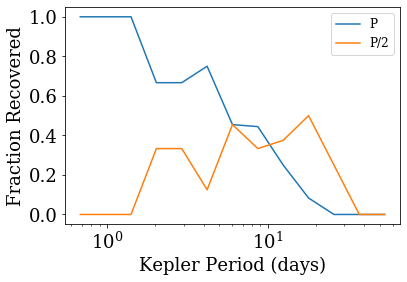

In [23]:
good = ((Trot1['LSper'][ok1]/Trot1['Period'][ok1] > 1-thresh) & 
        (Trot1['LSper'][ok1]/Trot1['Period'][ok1] < 1+thresh))
half = ((Trot1['LSper'][ok1]/Trot1['Period'][ok1] > 0.5-thresh) & 
        (Trot1['LSper'][ok1]/Trot1['Period'][ok1] < 0.5+thresh))

LSpfrac = np.zeros_like(pbins)-1
LShfrac = np.zeros_like(pbins)-1
LSe_pfrac = np.zeros((len(pbins), 2))-1
LSe_hfrac = np.zeros((len(pbins), 2))-1

for k in range(len(pbins)-1):
    
    pk = (Trot1['Period'].values[ok1] > pbins[k]) & (Trot1['Period'].values[ok1] <= (pbins[k+1]))
    den = float(sum(pk))
    num = float(sum(good[pk]))
    hal = float(sum(half[pk]))
    
    if den>0:
        LSpfrac[k] = num/den
        LShfrac[k] = hal/den
        LSe_pfrac[k,:] = funcs.binom_conf_interval(num, den)
        LSe_hfrac[k,:] = funcs.binom_conf_interval(hal, den)

plt.figure()
plt.plot(xx[np.where((LSpfrac > -1))], LSpfrac[np.where((LSpfrac > -1))], label='P')
plt.plot(xx[np.where((LShfrac > -1))], LShfrac[np.where((LShfrac > -1))], label='P/2')

plt.legend(fontsize=12)
plt.xscale('log')
plt.xlabel('Kepler Period (days)')
plt.ylabel('Fraction Recovered')

Text(0, 0.5, 'Fraction Recovered')

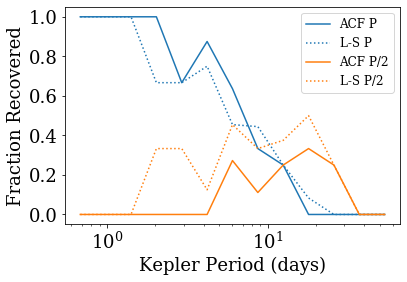

In [24]:
# plt.figure(figsize=(10,7))

plt.plot(xx[np.where((pfrac > -1))], pfrac[np.where((pfrac > -1))], label='ACF P', c='C0')
plt.plot(xx[np.where((LSpfrac > -1))], LSpfrac[np.where((LSpfrac > -1))], label='L-S P', c='C0', linestyle=':')

plt.plot(xx[np.where((hfrac > -1))], hfrac[np.where((hfrac > -1))], label='ACF P/2', c='C1')
plt.plot(xx[np.where((LShfrac > -1))], LShfrac[np.where((LShfrac > -1))], label='L-S P/2', c='C1', linestyle=':')

plt.legend(fontsize=12)
plt.xscale('log')
plt.xlabel('Kepler Period (days)')
plt.ylabel('Fraction Recovered')

# Reliability

Text(0, 0.5, 'Fraction Correct')

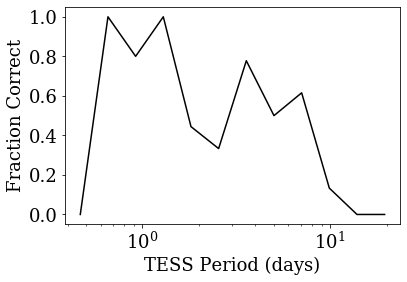

In [25]:
Rgood = ((Trot1['acf_per'][ok1]/Trot1['Period'][ok1] > 1-thresh) & 
         (Trot1['acf_per'][ok1]/Trot1['Period'][ok1] < 1+thresh))
Rhalf = ((Trot1['acf_per'][ok1]/Trot1['Period'][ok1] > 0.5-thresh) & 
         (Trot1['acf_per'][ok1]/Trot1['Period'][ok1] < 0.5+thresh))

pbins = np.logspace(-1, 1.8, num=20, dtype='float')
# pbins = np.arange(0, 55, 3., dtype='float')

Rpfrac = np.zeros_like(pbins)-1
Re_pfrac = np.zeros((len(pbins), 2))-1

for k in range(len(pbins)-1):
    pk = (Trot1['acf_per'].values[ok1] > pbins[k]) & (Trot1['acf_per'].values[ok1] <= (pbins[k+1]))
    den = float(sum(pk))
    num = float(sum(Rgood[pk]))
    
    if den>0:
        Rpfrac[k] = num/den
        Re_pfrac[k,:] = funcs.binom_conf_interval(num, den)
        
xx = ((pbins[:-1] + pbins[1:])/2)
plt.figure()
plt.plot(xx[np.where((Rpfrac > -1))], Rpfrac[np.where((Rpfrac > -1))], label='ACF', c='k')
# plt.errorbar(xx[np.where((Rpfrac > -1))], Rpfrac[np.where((Rpfrac > -1))], 
#              yerr = Re_pfrac[np.where((Rpfrac > -1))[0], :].T, linestyle='none', c='C0')

# plt.legend(fontsize=12)
plt.xscale('log')
plt.xlabel('TESS Period (days)')
plt.ylabel('Fraction Correct')

/Users/james/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


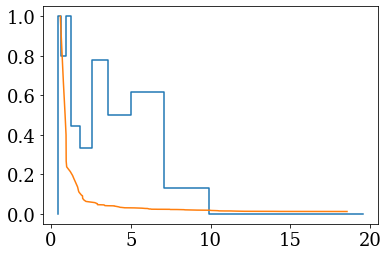

In [48]:
# TRY a continuous version, instead of bins (I did this before, but deleted it...)
TPsort = np.argsort(Trot1['acf_per'][ok1])
Rcok = np.cumsum(Rgood.values[TPsort]) / np.cumsum(np.arange(len(TPsort)))

plt.step(xx[np.where((Rpfrac > -1))], Rpfrac[np.where((Rpfrac > -1))])
plt.plot(Trot1['acf_per'][ok1].values[TPsort], Rcok)

(0, 1)

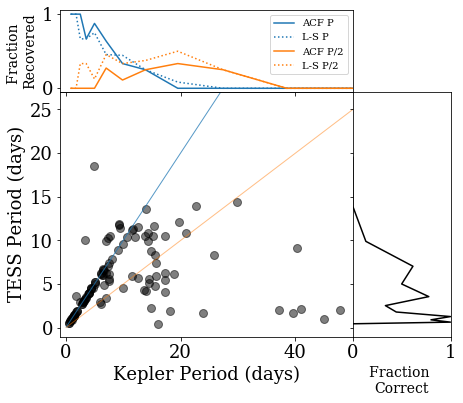

In [26]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(7, 6))
grid = plt.GridSpec(4, 4, hspace=0., wspace=0.)
main_ax = fig.add_subplot(grid[1:,:-1])
y_hist = fig.add_subplot(grid[1:,-1], sharey=main_ax)
x_hist = fig.add_subplot(grid[0,:-1], sharex=main_ax)
x_hist.xaxis.set_tick_params(labelbottom=False)
y_hist.yaxis.set_tick_params(labelbottom=False)

# # scatter points on the main axes
main_ax.plot(Trot1['Period'][ok1], Trot1['acf_per'][ok1], alpha=0.5, c='k', 
             markersize=8, marker='o', linestyle='none',)
main_ax.plot(Trot2['Period'][ok2], Trot2['acf_per'][ok2], alpha=0.5, c='k', 
             markersize=8, marker='o', linestyle='none',)

# main_ax.set_xscale('log')
# main_ax.set_yscale('log')

main_ax.set_xlabel('Kepler Period (days)')
main_ax.set_ylabel('TESS Period (days)')
main_ax.set_xlim(-1,50)
main_ax.set_ylim(-1,27)

main_ax.plot([.1,50], [.1, 50], c='C0', lw=1, alpha=0.75)
main_ax.plot([.1,50], [.05, 25], c='C1', lw=1, alpha=0.5)

# Top hist
# x_hist.plot(xx[np.where((pfrac > -1))], pfrac[np.where((pfrac > -1))], c='C0')
x_hist.plot(xx[np.where((pfrac > -1))], pfrac[np.where((pfrac > -1))], label='ACF P', c='C0')
x_hist.plot(xx[np.where((LSpfrac > -1))], LSpfrac[np.where((LSpfrac > -1))], label='L-S P', c='C0', linestyle=':')
x_hist.plot(xx[np.where((hfrac > -1))], hfrac[np.where((hfrac > -1))], label='ACF P/2', c='C1')
x_hist.plot(xx[np.where((LShfrac > -1))], LShfrac[np.where((LShfrac > -1))], label='L-S P/2', c='C1', linestyle=':')

x_hist.set_ylabel('Fraction \nRecovered', fontsize=14)
x_hist.legend(fontsize=10)

# Right hist
y_hist.plot(Rpfrac[np.where((Rpfrac > -1))],xx[np.where((Rpfrac > -1))], c='k')
y_hist.set_xlabel('Fraction \nCorrect', fontsize=14)
y_hist.set_xlim(0,1)

# plt.savefig('KvT_0.20.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [27]:
# spit out TICs for short period contaminents for Keaton
fK = np.where((Trot1['Period'][ok1] > 10) & (Trot1['acf_per'][ok1]< 4))[0]
print(np.shape(fK))

for k in range(len(fK)):
    print(Trot1['TIC'][ok1].values[fK][k], 
          format(Trot1['Period'][ok1].values[fK][k], '10.5f'),
          format(Trot1['acf_per'][ok1].values[fK][k], '10.5f') )

(8,)
164654552   39.59000    1.67567
121022767   37.05700    1.99372
171098521   47.76900    2.07708
121939266   18.22000    1.91456
172422313   41.02100    2.20139
27533798   44.94700    0.96111
416266231   16.11400    0.43611
164833828   23.85900    1.73679


In [65]:
Tbins

array([2800., 2900., 4000., 4500., 4650., 4800., 4950., 5100., 5250.,
       5400., 5550., 5700., 5850., 6000., 6150., 6300., 6450., 6600.,
       6750., 6900., 7050., 7200., 7350.])

76


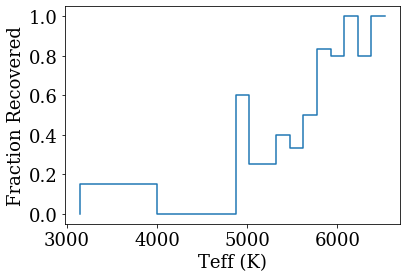

In [71]:
# TESS recovery as a function of Teff

Tbins = np.concatenate(([2800, 3500], np.arange(4500,7500,150, dtype='float')))
Tfrac = np.zeros_like(Tbins)-1

for k in range(len(Tbins)-1):
    pk = (Trot1['Teff'].values[ok1] > Tbins[k]) & (Trot1['Teff'].values[ok1] <= (Tbins[k+1]))
    den = float(sum(pk))
    num = float(sum(Rgood[pk]))
    
    if den>0:
        Tfrac[k] = num/den

Tx = ((Tbins[:-1] + Tbins[1:])/2)

plt.figure()
plt.step(Tx[np.where((Tfrac > -1))], Tfrac[np.where((Tfrac > -1))])
plt.xlabel('Teff (K)')
plt.ylabel('Fraction Recovered')

print(len(Rgood))

In [28]:
Trot1.columns

Index(['Unnamed: 0', 'TIC', 'LSper', 'LSamp', 'LSmed', 'LSstd', 'acf_pk',
       'acf_per', 'bls_per', 'bls_ampl', 'ecl_num', 'ecl_dep', 'KID', 'Period',
       'Teff', 'KIC'],
      dtype='object')

In [37]:
Rgood.shape

(76,)

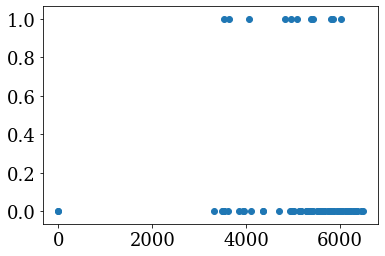

In [60]:
plt.scatter(Trot1['Teff'][ok1].values, Rgood)